In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config_custom as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
# from nidaqmx.stream_readers import AnalogSingleChannelReader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# connect to devices
pg  = PulseGenerator(ip=hcf.PS_IP, chmap=hcf.PS_chmap) 
mwsyn = Synthesizer(hcf.VDISYN_SN, 
                    vidpid=hcf.VDISYN_VIDPID,
                    baudrate=hcf.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hcf.LASER_SN)
laser.open()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.1.26
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


In [3]:
current_percent = 75.09
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [4]:
from hardware.daq.sidig import FIFO_DataAcquisition
from hardware.daq.sidig import FIFO_DataAcquisition, DCCOUPLE, TERMIN_INPUT_50OHM, TERMIN_INPUT_1MOHM

SIDIG_ADDRESS = "dev/spcm0"
SIDIG_maxsr = 500e6  # Hz
SIDIG_timebase = int(1 / SIDIG_maxsr * 1e9)  # ns
dig=FIFO_DataAcquisition(
                sn_address=SIDIG_ADDRESS
            )

Clock mode set to: 32
1: Internal, 2: Quartz, 3: External, 32: Direct External Sampling


In [5]:
freq = 16.6
errorbyte, freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.6 GHz
Actual Output CW Freqeuncy :16.600000005215406 GHz


In [6]:
# set MW power =====================================================
mwpower_vlevel = 5.0 # 5V equals to max power
task_uca = nidaqmx.Task("UCA") # user controlled attenuation
task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0.0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_uca.start()
task_uca.write([mwpower_vlevel], auto_start=False)
# task_uca.stop()
# task_uca.close()

1

In [7]:
dur_pt = 16E6 # duration of each frequency point
dig_trig_len=20
divpart_pt = 2
clock_rate = 500E-6 #GHz
daqtrig_delay = 1/clock_rate #delay
seq_daqtrig = [(dur_pt/2.0, HIGH), (dur_pt/2.0, LOW)]
seq_laser = [(dur_pt, HIGH)]
seq_mwA = [(dur_pt/2.0/divpart_pt, HIGH), (dur_pt/2.0/divpart_pt, LOW)]*divpart_pt
seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*int(dur_pt*clock_rate)
# seq_dig= [(dur_pt/2.0/divpart_pt, LOW), (dig_trig_len,HIGH),(dur_pt/2.0/divpart_pt/2-2*dig_trig_len, LOW),(dig_trig_len,HIGH),(dur_pt/2.0/divpart_pt/2-2*dig_trig_len, LOW)]*divpart_pt
seq_dig= [(dig_trig_len,HIGH), (dur_pt/2.0/divpart_pt-dig_trig_len, LOW),(dig_trig_len,LOW),(dig_trig_len,HIGH), (dur_pt/2.0/divpart_pt-dig_trig_len, LOW)]*divpart_pt

pg.setDigital("laser", seq_laser)
pg.setDigital("mwA", seq_mwA)
pg.setDigital('sdtrig',seq_dig)
# pg.setDigital("laser", seq_mwA)
# pg.setDigital("mw_A", seq_laser)
# pg.setDigital("dtrig", seq_daqtrig)
# pg.setDigital("dclk", seq_clock)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
pg.plotSeq(plot_all=False)

In [8]:
dig_trig_len = 20
divpart_pt = 2

mw_dur = 16e6//4

seq_laser = [(mw_dur, HIGH)]
seq_mwA = [
    (mw_dur, HIGH),
    (mw_dur, LOW),
] * divpart_pt

seq_dig = [
    (dig_trig_len, HIGH),
    (mw_dur - dig_trig_len, LOW),
    (dig_trig_len, LOW),
    (dig_trig_len, HIGH),
    (mw_dur - dig_trig_len, LOW),
] * divpart_pt

pg.setDigital("laser", seq_laser)
pg.setDigital("mwA", seq_mwA)
pg.setDigital("sdtrig", seq_dig)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
pg.plotSeq(plot_all=False)

In [9]:
def seqtime_tb(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])
def seqtime_cb(seq_cb):
    return np.sum([pulse[-0] for pulse in seq_cb])

In [10]:
## set up the data aquication with the digitizer 
# min_volt = -0.002 # [V]
# max_volt = 0.010 # [V]
mw_len=dur_pt/2.0/divpart_pt
t_seq = seqtime_cb(seq_laser)
rate_refresh = 1 # Hz rate of refreshing the data streaming
amp_input = 1000
readout_ch = hcf.SIDIG_chmap["apd"]
num_segment = int(2/rate_refresh*1e9/t_seq)//32*32

# configures the readout to match the pulse sequence  
pretrig_size= 256 #int((mw_len//2)*hcf.SIDIG_maxsr/1E9)//64*64 # pretrigger based on the t_wait time
# posttrig_size=int((t_ribloc+t_ribloc_isc)*hcf.SIDIG_maxsr/1E9)//64*64 # posttrigger based on the t_laser time and t_isc
posttrig_size=int((mw_len//2)*hcf.SIDIG_maxsr/1E9)//64*64 # posttrigger based on the t_laser time and t_isc

segment_size = pretrig_size+posttrig_size 
segment_size = 2**int(np.log2(segment_size)+1) # make it power of 2
posttrig_size = segment_size-pretrig_size # recalculate posttrigger size to ensure it is power of 2

In [11]:
# To set the configuration, make a dictionary with the key and value
dig.reset_param()
dig.assign_param(dict(
             readout_ch=readout_ch, 
             amp_input=amp_input, 
             num_segment=8,
             pretrig_size=16,
             posttrig_size=1048576//4-16,
             segment_size=1048576//4,
             terminate_input=TERMIN_INPUT_1MOHM,
             DCCOUPLE = 0,
             sampling_rate=hcf.SIDIG_maxsr
            #  terminate_input=TERMIN_INPUT_50OHM,
             ))


In [12]:
pretrig_size=128
posttrig_size=1024*1000-pretrig_size
# freq_start = 16.45-0.25
# freq_stop = 16.45+0.25
B = 14.103
f_e = 28.0249514242*B
f_NVp1 = f_e + 2.8705
f_NVm1 = f_e - 2.8705
# f_NVguess = 392.8397714495659
f_NVguess = 398.545
freq_start = (f_NVguess-0.015)/24.0
freq_stop = (f_NVguess+0.020)/24.0
# check the minium step size
freqminstep_list = mwsyn.get_min_step_size([freq_start], [freq_stop])
step_min = freqminstep_list[0] # in Hz
freq_step = 0.5E-3/24.0
freq_step = int(freq_step/step_min*1E9)*step_min/1E9/1.25

freq_array = np.arange(freq_start, freq_stop, freq_step)
freq_array=freq_array
# print(f"Estimated time for one sweep:{(freq_stop-freq_start)/freq_step*max(10E6, dur_pt)/1E9} s")
freq_actual = np.zeros(len(freq_array))

# Allocate arrays
signal = np.zeros((len(freq_actual), pretrig_size + posttrig_size))
background = np.zeros((len(freq_actual), pretrig_size + posttrig_size))

# Repeat measurement
num_repeat = 10
signal_av = np.zeros(len(freq_actual))
background_av = np.zeros(len(freq_actual))
segment_list = np.zeros(len(freq_actual))

laser.laser_on() # turn off laser

for mmm in range(num_repeat):
    for jj, ff in enumerate(freq_array):
        # print(f"Frequency: {ff} GHz")
        run_time = .1
        segments = 0
        
        dig.assign_param(dict(
            readout_ch=readout_ch,
            amp_input=amp_input,
            num_segment=8,
            pretrig_size=pretrig_size,
            posttrig_size=posttrig_size,
            segment_size=pretrig_size+posttrig_size,
            terminate_input=TERMIN_INPUT_1MOHM,
            DCCOUPLE=0,
            sampling_rate=hcf.SIDIG_maxsr 
        ))
        dig.set_config()
        errorbyte, freq_actual[jj] = mwsyn.cw_frequency(ff)
        pg.stream(n_runs=INF)  # Example function for pulse generator (replace with actual implementation)
        dig.start_buffer()
        pg.startNow()

        start_time = time.monotonic()
        while time.monotonic() - start_time < run_time:
            rawraw = dig.stream()
            assert rawraw.shape[0] % 2 == 0
            assert rawraw.shape[0] != 0

            rawraw_on = rawraw[0::2, :, :]
            rawraw_off = rawraw[1::2, :, :]
            segments += np.shape(rawraw)[0] // 2
            # print("hello")
            # signal[jj, :] += rawraw_on.reshape(-1, rawraw_on.shape[-1]).sum(axis=0)
            # background[jj, :] += rawraw_off.reshape(-1, rawraw_off.shape[-1]).sum(axis=0)
            # print(f"rawraw_on.shape[0]: {rawraw_on.shape[0]}")
            for ii in range(0,rawraw.shape[0] // 2):
                # print(f"Processing segment {ii} for freq index {jj}")
                signal[jj,:] += np.ravel(rawraw_on[ii])
                background[jj,:] += np.ravel(rawraw_off[ii])

        dig.stop_card()
        pg.forceFinal()
        # pg.reset()
        segment_list[jj] += segments


Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped

In [13]:
# turn off laser and set diode current to zero
laser.laser_off() 
laser.set_diode_current(0, save_memory=False)
laser.close()
# reset pulse generator
pg.forceFinal()
pg.constant(OutputState.ZERO())
pg.reset()
pg.reboot()

# close all NI tasks

task_uca.stop()
task_uca.close()

# reboot(optional) and close the MW synthesizer 
mwsyn.reboot()
mwsyn.close()

MW Synthesizer Rebooted!


In [14]:
def avg(data):
    return np.mean(data,axis=1)

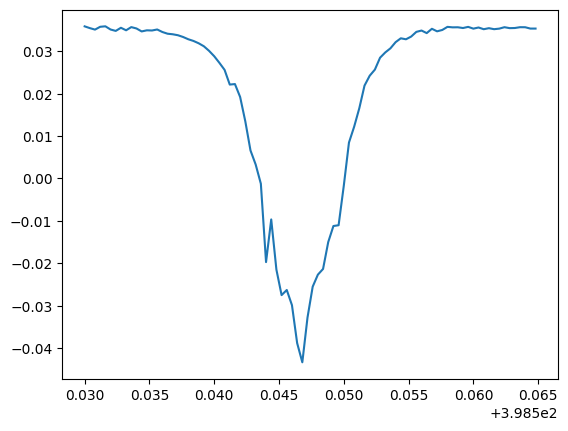

In [15]:
on=avg(signal)/segment_list
off=avg(background)/segment_list
plt.plot(freq_actual*24, (on-off)/off)

In [16]:
import plotly.graph_objects as go

# Assuming freq_actual, on, and off are defined arrays
trace = go.Scatter(
    x=freq_actual * 24,  # Multiply frequency by 24 for x-axis
    y=(on - off) / off,  # Compute y-axis values
    mode='lines',  # Line plot
    name='Plot'
)

# Create the figure
fig = go.Figure(trace)

# Customize layout (optional)
fig.update_layout(
    title="Plotly Plot",
    xaxis_title="Frequency (Adjusted)",
    yaxis_title="Normalized Difference",
    template="plotly_dark"
)

# Show the figure
fig.show()


In [36]:
def model_gaussian(freq, A, f0, sigma, C):
    """
    Gaussian model with a flat background.
    :param freq: Frequency array
    :param A: Amplitude of the Gaussian (can be positive or negative)
    :param f0: Center frequency
    :param sigma: Standard deviation (related to width)
    :param C: Flat background offset
    """
    return A * np.exp(-0.5 * ((freq - f0) / sigma) ** 2) + C

In [38]:
from scipy.optimize import curve_fit


In [79]:
def estimator_gaussian(freq, sig):
    """
    Estimate initial parameters for the Gaussian model.
    :param freq: Frequency array
    :param sig: Signal array
    :return: Initial guesses for A, f0, sigma, and C
    """
    # Estimate flat background (C) as the median of the signal
    C = np.median(sig)

    # Estimate amplitude (A) as the difference between the max and min signal
    A = np.max(sig) - np.min(sig)

    # Estimate center frequency (f0) as the frequency corresponding to the maximum absolute deviation
    f0 = freq[np.argmax(np.abs(sig - C))]

    # Estimate sigma as the range where the signal drops to ~37% (1/e) of the peak
    peak_index = np.argmax(np.abs(sig - C))
    half_max = np.abs(A) / np.exp(1)
    near_peak = np.abs(sig - C) > half_max
    if np.sum(near_peak) > 1:
        sigma = (freq[near_peak][-1] - freq[near_peak][0]) / (
            2 * np.sqrt(2 * np.log(2))
        )  # Convert FWHM to sigma
    else:
        sigma = (freq[-1] - freq[0]) / 10  # Default guess for sigma

    return [A, f0, np.abs(sigma), C]


In [80]:
initial_guess=estimator_gaussian(freq_actual*24, (on-off)/off-np.max((on-off)/off))

In [81]:
params, covaraince = curve_fit(model_gaussian,freq_actual*24, (on-off)/off-np.max((on-off)/off), p0=initial_guess)

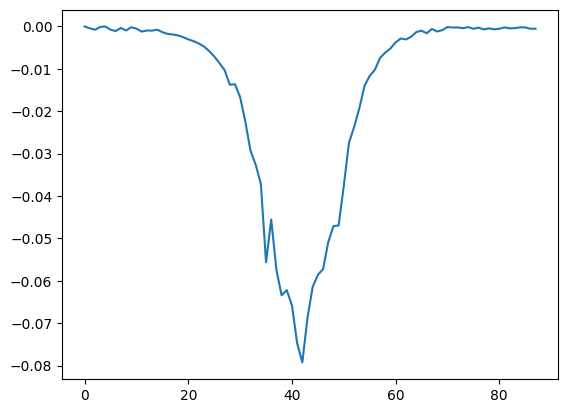

In [82]:
# plt.plot(on)
# plt.plot(off)
plt.plot((on-off)/off-np.max((on-off)/off))

In [85]:
x_smooth = np.linspace(min(freq_actual * 24), max(freq_actual * 24), 300)
y_fitted = model_gaussian(x_smooth, *params)
fig = go.Figure()

# Add original data points
fig.add_trace(go.Scatter(
    x=freq_actual * 24,
    y=(on - off) / off - np.max((on - off) / off),
    mode='markers',
    name='Data',
    marker=dict(size=6, color='blue')
))

# Add fitted curve
fig.add_trace(go.Scatter(
    x=x_smooth,
    y=y_fitted,
    mode='lines',
    name='Fitted Gaussian',
    line=dict(color='red', width=2)
))

# Customize layout
fig.update_layout(
    title="Gaussian Fit to Data",
    xaxis_title="Frequency (Adjusted)",
    yaxis_title="Normalized Difference",
    # template="plotly_dark"
)

# Show the plot
fig.show()


In [86]:
def get_fwhm(sigma):
    """Calculate Full Width at Half Maximum (FWHM) for a Gaussian function."""
    return 2 * np.sqrt(2 * np.log(2)) * sigma  # ≈ 2.355 * sigma


In [91]:
FWHM=get_fwhm(params[2]) # GHz

In [ ]:
gamma = 28 # GHz/T # https://magnetometryrp.quantumtinkerer.tudelft.nl/3_NVspin/

In [93]:
Amplitude_fit=params[0]
Amplitude_fit


-0.06942517000558811

In [ ]:
responsivity = abs(Amplitude_fit)/ ((FWHM) * gamma)
responsivity # 

0.37147883077930977